# Moramo urediti nase podatke sobzirom da nisam ostavio header u CSV moramo da dodamo schemu

In [0]:
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, BooleanType,LongType

# Define the schema
schema = StructType([
    StructField("id", LongType(), True),
    StructField("time", LongType(), True),
    StructField("user", StringType(), True),
    StructField("bot", BooleanType(), True),
    StructField("wiki", StringType(), True),
    # Add as many columns as you have in your CSV
])

# Read the CSV file
df = spark.read.format("csv").option("header", "false").schema(schema).load("dbfs:/FileStore/shared_uploads/pstamenic7721rn@raf.rs/output1.csv")

# Show the DataFrame
df.show()

+----------+----------+--------------------+-----+------------+
|        id|      time|                user|  bot|        wiki|
+----------+----------+--------------------+-----+------------+
|2133565291|1707251180|            KRLS Bot| true|wikidatawiki|
|1734155818|1707251179|              Cewbot| true|      enwiki|
|2428892928|1707251180|      FinnaUploadBot| true| commonswiki|
|1734155817|1707251179|          Polyamorph|false|      enwiki|
|  19648933|1707251179|               Xeyal|false|      azwiki|
|1734155819|1707251180|        KHR FolkMyth|false|      enwiki|
|2428892927|1707251180|         Poliocretes|false| commonswiki|
| 347625549|1707251180|                 PM3|false|      dewiki|
| 513388492|1707251179|               Vlaam|false|      frwiki|
|2428892929|1707251180|         GeographBot| true| commonswiki|
|2133565292|1707251180|     Трифонов Андрей|false|wikidatawiki|
|2133565293|1707251180|         Dcirovicbot| true|wikidatawiki|
|2428892930|1707251180|       Schlurcher

U ovoj Analici mozemo primetiti koje wikipedije je najvise menjaju <br>
potrebno prebrojati sve promene zabelezene za svaku od wikipedija <br>
potrebno nam je da proverimo koliko od tih promena je nastalo usred rada botova <br>

Ovo nam moze znaciti da vidimo koje vikipedije je potrebno staviti na vise servera ukoliko obradjuju veliki broj podataka a sa kojih mozemo skinuti servere ako nisu optereceni uopste <br>
Takodje mozemo da zakljucimo  na kojoj od ovih vikipedija najvise imamo botova.<br>
ukoliko bi broj botova na nekoj od wikipedija naglo porastao u buducem periodu to bi moglo predstavljati neku vrstu napada gde bi trebalo obratiti paznju<Br>
na primer kada bi odjednom na Ruskoj wikipediji se pojavilo 100 novih botova to bi predstavljalo porast od skoro 400% dok ukoliko se 100 novih botova pojavi na engleskoj vokipediji to je znatno manji procenat

In [0]:
from pyspark.sql.functions import col, count, sum

# Count total, bot, and non-bot entries for each wiki
wiki_summary = df.groupBy("wiki").agg(
    count("*").alias("total_entries"),
    sum(col("bot").cast("integer")).alias("bot_entries"),
    (count("*") - sum(col("bot").cast("integer"))).alias("non_bot_entries")
)

# Sort the summary by total_entries in descending order
sorted_wiki_summary = wiki_summary.orderBy(col("total_entries").desc())

# Show the sorted summarized table
sorted_wiki_summary.show()

+------------+-------------+-----------+---------------+
|        wiki|total_entries|bot_entries|non_bot_entries|
+------------+-------------+-----------+---------------+
| commonswiki|         9373|       3215|           6158|
|      enwiki|         8751|       6387|           2364|
|wikidatawiki|         7981|       4063|           3918|
|      eswiki|          604|        308|            296|
|      frwiki|          546|         22|            524|
|      dewiki|          382|         14|            368|
|      ruwiki|          353|         27|            326|
|      azwiki|          301|          0|            301|
|      itwiki|          235|          5|            230|
|      plwiki|          224|         21|            203|
|      nnwiki|          208|          0|            208|
|enwiktionary|          200|          0|            200|
|      arwiki|          143|         81|             62|
|eswiktionary|          140|        137|              3|
|      fawiki|          138|   

U ovom istrazivanju mozemo videti prosecno vreme izmedj 2 poruke kod korisnika i kod botova <br>
To nam moze pomoci da proverimo da li je neko od korisnika zapravo bot i da ga flagujemo.<Br>
ukoliko neko od korisnika nenormalno brzo pravi komentare to bi trebalo pregledati.<br>
Takodje ovo istrazivanje nam moze pomoci i da vidimo da li se nasi korisnici zadrzavaju na sajtu ili odlaze.<br>
ukoliko prosecno vreme izmedju 2 poruke pocne da raste za vecinu korisnika za vreme nekog duzeg vremenskog perioda to moze oznacavati da ti korisnici napustaju nas sajt.

In [0]:
from pyspark.sql.window import Window
from pyspark.sql.functions import col, lag, avg

# Define a window spec partitioned by user and ordered by time
window_spec = Window.partitionBy("user").orderBy("time")

# Calculate the time difference between consecutive comments
df_with_time_diff = df.withColumn("time_diff", col("time") - lag("time").over(window_spec))

# Filter out rows where time_diff is null or zero
df_filtered = df_with_time_diff.filter(col("time_diff").isNotNull() & (col("time_diff") != 0))

# Compute the average time difference per user
avg_time_diff_per_user = df_filtered.groupBy("user", "bot").agg(avg("time_diff").alias("avg_time_diff"))

# Filter for bots and sort by avg_time_diff
bot_avg_time_diff = avg_time_diff_per_user.filter(col("bot") == True).orderBy("avg_time_diff")

# Filter for regular users and sort by avg_time_diff
non_bot_avg_time_diff = avg_time_diff_per_user.filter(col("bot") == False).orderBy("avg_time_diff")

# Show results
print("Average time difference between comments for Bots:")
bot_avg_time_diff.show()

print("Average time difference between comments for Regular Users:")
non_bot_avg_time_diff.show()

Average time difference between comments for Bots:
+-----------------+----+------------------+
|             user| bot|     avg_time_diff|
+-----------------+----+------------------+
|DannyS712 bot III|true|               1.0|
|          Salebot|true|               1.0|
|      BlockBot-es|true|1.3828382838283828|
|    PastooshekBOT|true|               1.5|
|           Cewbot|true| 1.587719298245614|
|   Qwerfjkl (bot)|true|1.5982367758186398|
|    SchlurcherBot|true|1.8590308370044053|
|      Dcirovicbot|true|1.8742603550295858|
|           Jembot|true|               2.0|
|        SDZeroBot|true|               2.0|
| Simon Villeneuve|true|               2.0|
|        Emijrpbot|true|2.1153846153846154|
|       Cyberbot I|true|               3.0|
|          LiMrBot|true|3.2493573264781492|
|   FinnaUploadBot|true|3.5069252077562325|
|         KRLS Bot|true|3.7205882352941178|
|         ԱշբոտՏՆՂ|true| 4.861538461538461|
|         EmptyBot|true| 5.888888888888889|
|            KrBot|true| 

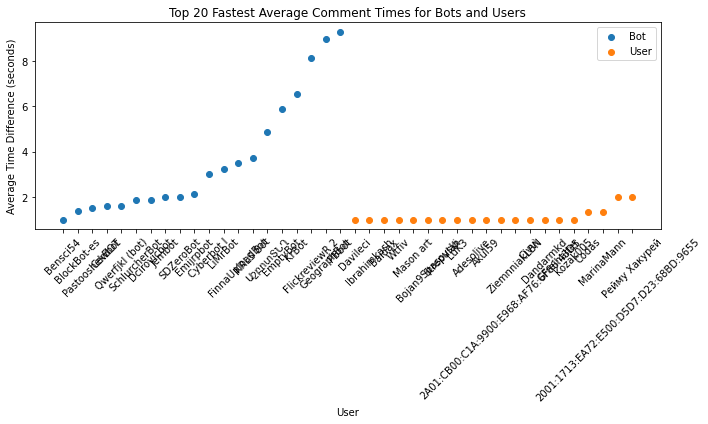

In [0]:
from pyspark.sql.functions import col, count, lag, avg
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt

# Define a window spec partitioned by user and ordered by time
window_spec = Window.partitionBy("user", "bot").orderBy("time")

# Calculate the time difference between consecutive comments
df_with_time_diff = df.withColumn("time_diff", col("time") - lag("time").over(window_spec))

# Filter out rows where time_diff is null or zero
df_filtered = df_with_time_diff.filter(col("time_diff").isNotNull() & (col("time_diff") != 0))

# Compute the average time difference per user
avg_time_diff_per_user = df_filtered.groupBy("user", "bot").agg(avg("time_diff").alias("avg_time_diff"))

# Drop duplicates for non-bot users based on avg_time_diff
unique_non_bot_users = avg_time_diff_per_user.filter(col("bot") == False).dropDuplicates(["user", "avg_time_diff"])

# Get top 20 fastest times for bots
top20_bots = avg_time_diff_per_user.filter(col("bot") == True).orderBy("avg_time_diff").select("user", "avg_time_diff").limit(20)

# Get top 20 fastest unique times for regular users
top20_users = unique_non_bot_users.orderBy("avg_time_diff").select("user", "avg_time_diff").limit(20)

# Convert to Pandas DataFrames for plotting
top20_bots_pd = top20_bots.toPandas()
top20_users_pd = top20_users.toPandas()

# Combine the data into a single DataFrame for easier plotting
top20_bots_pd["type"] = "Bot"
top20_users_pd["type"] = "User"
combined_data = pd.concat([top20_bots_pd, top20_users_pd])

# Plotting
plt.figure(figsize=(10, 6))
for label, df in combined_data.groupby('type'):
    plt.scatter(df['user'], df['avg_time_diff'], label=label)

plt.xlabel('User')
plt.ylabel('Average Time Difference (seconds)')
plt.title('Top 20 Fastest Average Comment Times for Bots and Users')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Kada proverimo broj korisnika sa istim vremenskim razmakom bitno mozemo primetiti da veliki broj korisnika nenormalno brzo pravi nove poruke <br>
taj broj korisnika u daljoj analizi je pogodno odstraniti<br>
odlucujemo da odstranimo bottom 5% kao potencijalne botove<br>
u ovom slucaju nije preporucivo odstraniti top5% jer to je onaj deo koji nas brine. To su korisnici koji gube interes u nas sajt i sve redje se pojavljuju.<br>
ako bi smo odradili i top5% to bi nam makismalno vreme smanjilo na pola( vec sam odradio i sa 1200 max je spalo na 600 max)<br>
sve do 600 sekundi izmedju 2 poruke mozemo uzeti kao da je korisnik zainteresovan jos uvek i da mu drzimo paznju<br>

In [0]:
from pyspark.sql.functions import col, avg, count

# Assuming bot_avg_time_diff and user_avg_time_diff are already defined as per previous steps

# Aggregate and count how many bots have the same average time
bot_time_aggregated = bot_avg_time_diff.groupBy("avg_time_diff").agg(count("*").alias("user_count")).orderBy("avg_time_diff")

# Aggregate and count how many regular users have the same average time
user_time_aggregated = unique_non_bot_users.groupBy("avg_time_diff").agg(count("*").alias("user_count")).orderBy("avg_time_diff")

# Show the results
print("Number of Bots with the Same Average Time Difference:")
bot_time_aggregated.show()

print("Number of Regular Users with the Same Average Time Difference:")
user_time_aggregated.show()


Number of Bots with the Same Average Time Difference:
+------------------+----------+
|     avg_time_diff|user_count|
+------------------+----------+
|               1.0|         2|
|1.3828382838283828|         1|
|               1.5|         1|
| 1.587719298245614|         1|
|1.5982367758186398|         1|
|1.8590308370044053|         1|
|1.8742603550295858|         1|
|               2.0|         3|
|2.1153846153846154|         1|
|               3.0|         1|
|3.2493573264781492|         1|
|3.5069252077562325|         1|
|3.7205882352941178|         1|
| 4.861538461538461|         1|
| 5.888888888888889|         1|
| 6.518518518518518|         1|
| 8.134228187919463|         1|
| 8.943262411347519|         1|
| 9.279411764705882|         1|
|              10.0|         2|
+------------------+----------+
only showing top 20 rows

Number of Regular Users with the Same Average Time Difference:
+------------------+----------+
|     avg_time_diff|user_count|
+------------------+-----

In [0]:
bot_time_aggregated_pd = bot_time_aggregated.toPandas()
user_time_aggregated_pd = user_time_aggregated.toPandas()

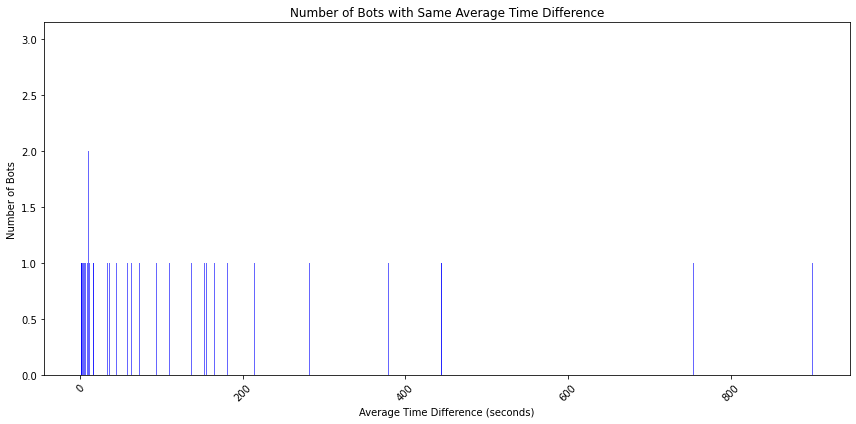

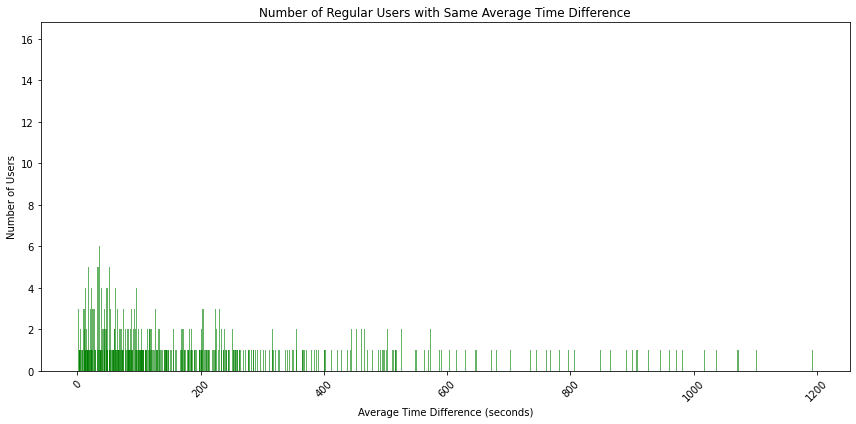

In [0]:

# Plot for bots
plt.figure(figsize=(12, 6))
plt.bar(bot_time_aggregated_pd['avg_time_diff'], bot_time_aggregated_pd['user_count'], color='blue', alpha=0.6)
plt.title('Number of Bots with Same Average Time Difference')
plt.xlabel('Average Time Difference (seconds)')
plt.ylabel('Number of Bots')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot for regular users
plt.figure(figsize=(12, 6))
plt.bar(user_time_aggregated_pd['avg_time_diff'], user_time_aggregated_pd['user_count'], color='green', alpha=0.6)
plt.title('Number of Regular Users with Same Average Time Difference')
plt.xlabel('Average Time Difference (seconds)')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [0]:
from pyspark.sql.functions import col, lit
from pyspark.sql.window import Window
from pyspark.sql.functions import percent_rank

# Assuming user_avg_time_diff is the DataFrame with the average time differences for regular users

# Calculate the percentile rank for each user
window = Window.orderBy("avg_time_diff")
user_avg_time_diff = unique_non_bot_users.withColumn("percentile_rank", percent_rank().over(window))

# Find the threshold for the 5th percentile
threshold = user_avg_time_diff.approxQuantile("avg_time_diff", [0.05], 0.0)[0]

# Filter out the bottom 5% of the data
filtered_user_data = user_avg_time_diff.filter(col("avg_time_diff") > lit(threshold))

# Show the result
filtered_user_data.show()


+--------------------+-----+------------------+--------------------+
|                user|  bot|     avg_time_diff|     percentile_rank|
+--------------------+-----+------------------+--------------------+
|           HapHaxion|false|12.666666666666666|0.052583025830258305|
|         Samoasambia|false|              13.0| 0.05350553505535055|
|               Ulamm|false|              13.0| 0.05350553505535055|
|        Beşiktaşlı48|false|              13.0| 0.05350553505535055|
|          Montgomery|false|              13.0| 0.05350553505535055|
|          JWilz12345|false|              13.2| 0.05719557195571956|
|       SecretName101|false|              13.5|0.058118081180811805|
|             Mitsjol|false|13.583333333333334| 0.05904059040590406|
|           SpiderMum|false|              14.0| 0.05996309963099631|
|Yuval12345678910y...|false|              14.0| 0.05996309963099631|
|            Джекалоп|false|              14.0| 0.05996309963099631|
|               Murli|false|      

<command-975141197414268>:12: UserWarning: Glyph 2438 (\N{BENGALI LETTER AA}) missing from current font.
  plt.tight_layout()
<command-975141197414268>:12: UserWarning: Matplotlib currently does not support Bengali natively.
  plt.tight_layout()
<command-975141197414268>:12: UserWarning: Glyph 2475 (\N{BENGALI LETTER PHA}) missing from current font.
  plt.tight_layout()
<command-975141197414268>:12: UserWarning: Glyph 2468 (\N{BENGALI LETTER TA}) missing from current font.
  plt.tight_layout()
<command-975141197414268>:12: UserWarning: Glyph 2494 (\N{BENGALI VOWEL SIGN AA}) missing from current font.
  plt.tight_layout()
<command-975141197414268>:12: UserWarning: Glyph 2476 (\N{BENGALI LETTER BA}) missing from current font.
  plt.tight_layout()
<command-975141197414268>:12: UserWarning: Glyph 2497 (\N{BENGALI VOWEL SIGN U}) missing from current font.
  plt.tight_layout()
<command-975141197414268>:12: UserWarning: Glyph 2460 (\N{BENGALI LETTER JA}) missing from current font.
  plt.tight

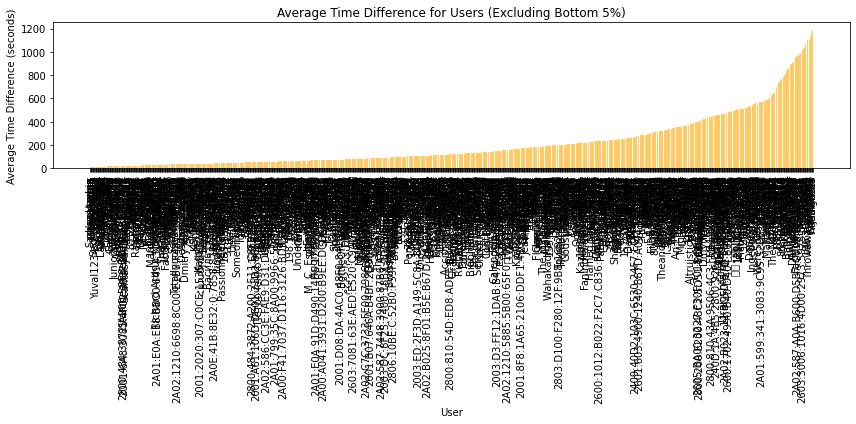

In [0]:
filtered_user_data_pd = filtered_user_data.toPandas()

import matplotlib.pyplot as plt

# Plotting the filtered user data
plt.figure(figsize=(12, 6))
plt.bar(filtered_user_data_pd['user'], filtered_user_data_pd['avg_time_diff'], color='orange', alpha=0.6)
plt.title('Average Time Difference for Users (Excluding Bottom 5%)')
plt.xlabel('User')
plt.ylabel('Average Time Difference (seconds)')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.tight_layout()
plt.show()